# Importing the libraries

TODO: What about the duplicate rows? Should we remove them? Yes.

TODO: Should we use a specific random_state? No.

TODO: Should we use a scaler? Which is better?.

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import confusion_matrix, accuracy_score, classification_report
import warnings
warnings.filterwarnings("ignore") # This is to ignore warnings coming out of models due to low number of epochs, ...etc


In [3]:
random_state = 42


# Importing the dataset, preprocessing and analyzing it

## Importing the dataset

In [4]:
dataset = pd.read_csv("datasets/COVID19_outcome.csv")


Let's view the shape of the dataset.

In [5]:
dataset.shape


(863, 15)

As described inside the project description, we have 14 features but as shown above, the shape of the dataset is (863, 15). Let's view the first 5 rows of the dataset.

In [6]:
dataset.head()


,Unnamed: 0,location,country,gender,age,vis_wuhan,from_wuhan,symptom1,symptom2,symptom3,symptom4,symptom5,symptom6,diff_sym_hos,result
0,0,104,8,1,66.0,1,0,14,31,19,12,3,1,8,1
1,1,101,8,0,56.0,0,1,14,31,19,12,3,1,0,0
2,2,137,8,1,46.0,0,1,14,31,19,12,3,1,13,0
3,3,116,8,0,60.0,1,0,14,31,19,12,3,1,0,0
4,4,116,8,1,58.0,0,0,14,31,19,12,3,1,0,0


As shown above there is an extra column called "Unnamed: 0" which contains the index of each row. Let's drop this column.

Note: Pandas named this column as it doesn't have a name.

In [7]:
dataset.drop(["Unnamed: 0"], axis=1, inplace=True)


Now let's view the shape again.

In [8]:
dataset.shape


(863, 14)

Much better!!!

Now let's view some information about the dataset.

In [9]:
dataset.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 863 entries, 0 to 862
Data columns (total 14 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   location      863 non-null    int64  
 1   country       863 non-null    int64  
 2   gender        863 non-null    int64  
 3   age           863 non-null    float64
 4   vis_wuhan     863 non-null    int64  
 5   from_wuhan    863 non-null    int64  
 6   symptom1      863 non-null    int64  
 7   symptom2      863 non-null    int64  
 8   symptom3      863 non-null    int64  
 9   symptom4      863 non-null    int64  
 10  symptom5      863 non-null    int64  
 11  symptom6      863 non-null    int64  
 12  diff_sym_hos  863 non-null    int64  
 13  result        863 non-null    int64  
dtypes: float64(1), int64(13)
memory usage: 94.5 KB


Let's check if there are any missing values.

In [10]:
dataset.isna().sum()


location        0
country         0
gender          0
age             0
vis_wuhan       0
from_wuhan      0
symptom1        0
symptom2        0
symptom3        0
symptom4        0
symptom5        0
symptom6        0
diff_sym_hos    0
result          0
dtype: int64

Now Let's find out if there are any duplicate rows.

In [11]:
duplicates_count = 0
for x in dataset.duplicated():
    if x == True:
        duplicates_count += 1

print("Duplicates : ", duplicates_count)


Duplicates :  168


We have 168 rows that are duplicates. Let's drop them.

In [12]:
index = 0
for x in dataset.duplicated():
    if (x == True):
        dataset.drop([index], axis=0, inplace= True)
    index+=1


Let's view the duplicate rows again to make sure they are dropped.


In [13]:
duplicates_count = 0
for x in dataset.duplicated():
    if (x == True):
        duplicates_count+=1

print("Duplicates : ", duplicates_count)


Duplicates :  0


Note that the `.duplicated()` method ignores (marks as False) the first occurence of the duplicated rows and marks the rest as True. For example:

```python
temp = [[1,4,1],
        [1,5,1],
        [3,6,0],
        [8,4,1],
        [1,4,1],
        [1,4,0],
        [3,6,0],
        [5,1,1],
        [9,4,0],
        [1,7,0]]
pd.DataFrame(temp).duplicated()
```

will return:

```
0    False
1    False
2    False
3    False
4     True --> This row is a duplicate of row 0.
5    False
6     True --> This row is a duplicate of row 2.
7    False
8    False
9    False
dtype: bool
```


In [14]:
dataset.describe()


,location,country,gender,age,vis_wuhan,from_wuhan,symptom1,symptom2,symptom3,symptom4,symptom5,symptom6,diff_sym_hos,result
count,695.000000,695.000000,695.000000,695.000000,695.000000,695.000000,695.000000,695.000000,695.000000,695.000000,695.000000,695.000000,695.000000,695.000000
mean,75.965468,16.477698,0.686331,49.507338,0.205755,0.128058,11.700719,27.277698,18.129496,11.801439,2.991367,0.998561,1.234532,0.152518
std,38.605392,7.468802,0.606901,16.506778,0.404544,0.334395,4.332664,8.165031,3.168729,1.316378,0.141768,0.037932,2.571953,0.359781
min,0.000000,0.000000,0.000000,2.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,-5.000000,0.000000
25%,45.000000,8.000000,0.000000,37.000000,0.000000,0.000000,6.000000,31.000000,19.000000,12.000000,3.000000,1.000000,0.000000,0.000000
50%,83.000000,18.000000,1.000000,49.400000,0.000000,0.000000,14.000000,31.000000,19.000000,12.000000,3.000000,1.000000,0.000000,0.000000
75%,108.000000,23.000000,1.000000,60.000000,0.000000,0.000000,14.000000,31.000000,19.000000,12.000000,3.000000,1.000000,1.000000,0.000000
max,138.000000,33.000000,2.000000,96.000000,1.000000,1.000000,24.000000,31.000000,19.000000,12.000000,3.000000,1.000000,15.000000,1.000000


## Let's work on the outliers

## Exploratory Data Analysis

### Visualizing Data Distributions

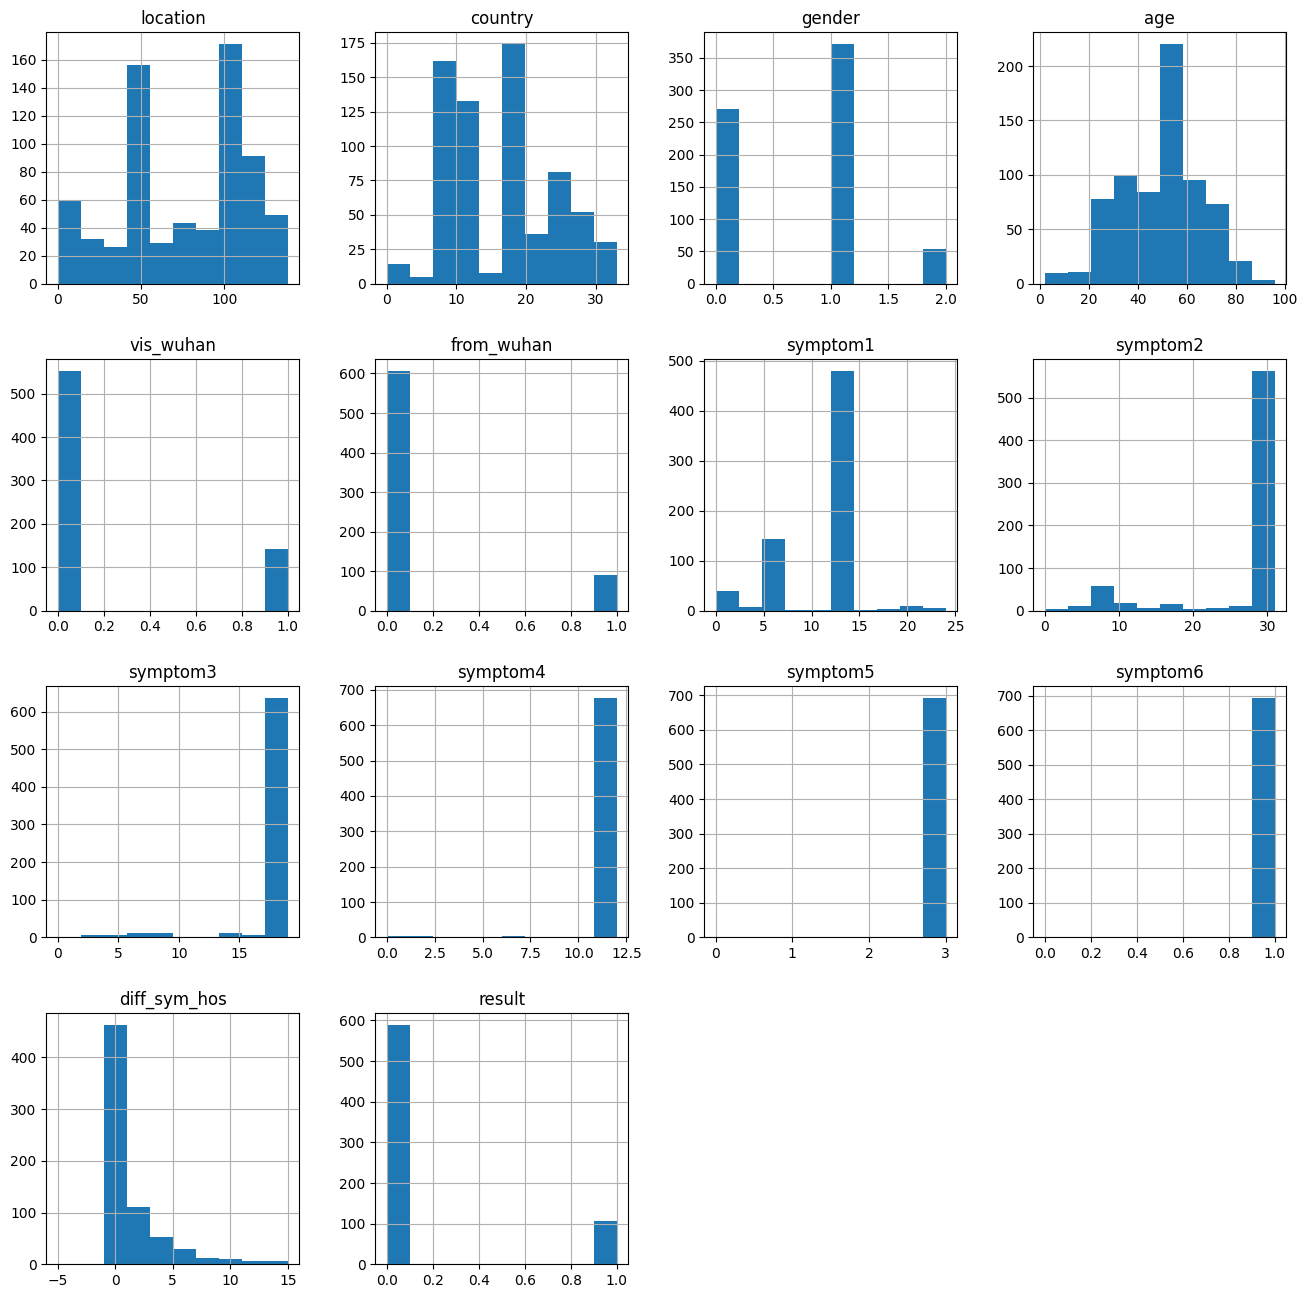

In [15]:
dataset.hist(figsize=(16, 16))
plt.show()


### Visualizing feature correlations

This is the covariance matrix

```
      0           1           2           ...  n
    -------------------------------------------------------
0   | Var(0)      Covar(0,1)  Covar(0,2)  ...  Covar(0,n) |
    -------------------------------------------------------
1   | Covar(1,0)  Var(1)      Covar(1,2)  ...  Covar(1,n) |
    -------------------------------------------------------
2   | Covar(2,0)  Covar(2,1)  Var(2)      ...  Covar(2,n) |
    -------------------------------------------------------
... | ...         ...         ...         ...  ...        |
    -------------------------------------------------------
n   | Covar(n,0)  Covar(n,1)  Covar(n,2)  ...  Var(n)     |
    -------------------------------------------------------
```

So for example:

${covariance}(X, Y) = \frac{\sum_{i=1}^{n}(X_i - \bar{X})(Y_i - \bar{Y})}{n-1}$

The mean of variable $X$ is calculated as $\bar{X} = \frac{\sum_{i=1}^{n} X_i}{n}$, and the mean of variable $Y$ is calculated as $\bar{Y} = \frac{\sum_{i=1}^{n} Y_i}{n}$.

Let's calculate the `covariance(location,location)` OR `covariance(0,0)` OR `variance(location)` OR `variance(0)` and the `covariance(location,country)` OR `covariance(0,1)` to make sure that the covariance matrix is correct.

```python

# Calculating the covariance(location,location) OR covariance(0,0) OR variance(location) OR variance(0)

n = COVID_19_outcome_dataset.shape[0]

x1 = COVID_19_outcome_dataset.iloc[:,0].values
y1 = x1

x1bar = np.mean(x1)
y1bar = x1bar

v_x1 = np.sum((x1 - x1bar) ** 2)
v_y1 = np.sum((y1 - y1bar) ** 2)

cov1_numerator = np.sum((x1 - x1bar) * (y1 - y1bar))
cov1 = cov1_numerator / ( n - 1)

correlation1_coefficient = cov1_numerator / (np.sqrt(v_x1) * np.sqrt(v_y1))

correlation1_coefficient

```

Will return:

```
1.0000000000000002
```

```python

# Calculating the covariance(location,country) OR covariance(0,1)

n = COVID_19_outcome_dataset.shape[0]

x2 = COVID_19_outcome_dataset.iloc[:,0].values
y2 = COVID_19_outcome_dataset.iloc[:,1].values

x2bar = np.mean(x2)
y2bar = np.mean(y2)

v_x2 = np.sum((x2 - x2bar) ** 2)
v_y2 = np.sum((y2 - y2bar) ** 2)

cov2_numerator = np.sum((x2 - x2bar) * (y2 - y2bar))
cov2 = cov2_numerator / (n - 1)

correlation2_coefficient = cov2_numerator / (np.sqrt(v_x2) * np.sqrt(v_y2))

correlation2_coefficient

```

Will return:

```
0.3093467486067619
```

Let's check the correlation matrix.

```python

corr = COVID_19_outcome_dataset.drop("result",axis= 1, inplace= False).corr()

corr["location"]["location"]

```

Will return:

```
1.0
```

```python

corr = COVID_19_outcome_dataset.drop("result",axis= 1, inplace= False).corr()

corr["location"]["country"]

```

Will return:

```
0.30934674860676165
```



We drop the target column to view the correlations between the features BUT we set `inplace` to False so that the original dataset is not affected.

In [16]:
corr = dataset.drop("result", axis=1, inplace=False).corr()


#### Let's draw the heatmap.


Here we only show the high(>0.5) and low(<-0.5) corr graph.

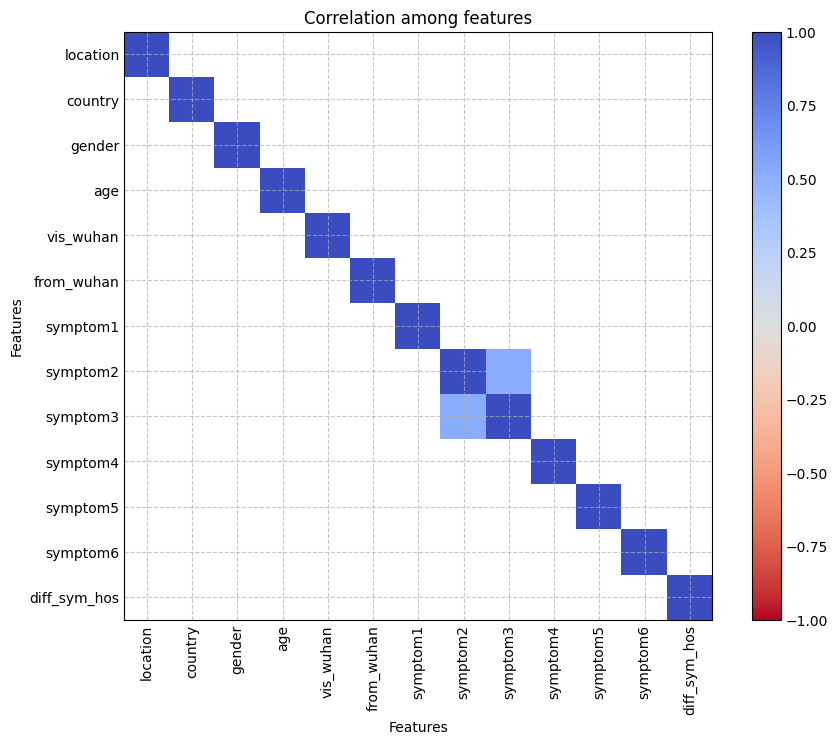

In [17]:
plt.style.use("_mpl-gallery-nogrid")

fig, ax = plt.subplots(figsize=(8, 6))
labels = dataset.columns.drop(
    "result"
)  # Column labels but remove the result (target) column.
features_count = dataset.shape[1]
filtered_corr = corr[(corr > 0.5) | (corr < -0.5)]
hm = ax.imshow(
    filtered_corr, cmap="coolwarm_r", interpolation="nearest", aspect="equal"
)
ax.set_xticks(
    np.arange(0, features_count - 1), labels=labels, rotation="vertical", ha="center"
)  # X-axis scale and labels
ax.set_yticks(
    np.arange(0, features_count - 1), labels=labels
)  # Y-axis scale and labels
ax.grid(visible=True, linestyle="--", alpha=0.7)
ax.set(title="Correlation among features", xlabel="Features", ylabel="Features")
hm.set_clim((-1, 1))
cbar = fig.colorbar(mappable=hm)  # This is the color bar at the right
plt.show()


From the above heatmap, we observe that `symptom1` and `symptom2` are slightly correlated. Same with `symptom2` and `symptom3`.

# Model Building

## Splitting the dataset into the Training set and Test set

In [18]:
X = dataset.drop("result", axis=1, inplace=False).values
Y = dataset["result"].values


In [19]:
X_train, X_test, Y_train, Y_test = train_test_split(
    X, Y, test_size=0.2, shuffle=True, random_state=random_state
)
for n, d in [
    ("X_train", X_train),
    ("X_test", X_test),
    ("Y_train", Y_train),
    ("Y_test", Y_test),
]:
    print(f"{n} Shape= {d.shape}")


X_train Shape= (556, 13)
X_test Shape= (139, 13)
Y_train Shape= (556,)
Y_test Shape= (139,)


## Scaling Data

This StandardScaler will scale the data to be inside the range of -3 and 3 inclusive.

In [20]:
sc = StandardScaler()
sc.fit_transform(X_train)
sc.transform(X_test)


array([[ 0.86322316,  0.98376124, -1.09971441, ...,  0.05891329,
         0.        , -0.49512624],
       [ 1.25559732,  1.11805322, -1.09971441, ...,  0.05891329,
         0.        , -0.49512624],
       [-0.8109066 ,  0.17800934, -1.09971441, ...,  0.05891329,
         0.        , -0.11383789],
       ...,
       [-1.80492114, -0.76203455,  0.52214557, ...,  0.05891329,
         0.        , -0.49512624],
       [-1.64797148, -0.62774256,  0.52214557, ...,  0.05891329,
         0.        , -0.49512624],
       [-0.05231655,  0.58088529, -1.09971441, ...,  0.05891329,
         0.        , -0.49512624]])

## Model Training and Prediction
 - K-Nearest Neighbors (KNN)
 - Logistic Regression (LR)
 - Naïve Bayes (NB)
 - Decision Trees (DT)
 - Support Vector Machines (SVM)
### We test these models and evaluate the predictive performance of each model.  

In [21]:
models = {
    "KNN": KNeighborsClassifier(),
    "LR": LogisticRegression(),
    "NB": GaussianNB(),
    "DT": DecisionTreeClassifier(),
    "SVM": SVC(),
}


In [22]:
# KNNModel= models["KNN"].fit(X_train, Y_train)
# KNNPred= KNNModel.predict(X_test)
# LRModel= models["LR"].fit(X_train, Y_train)
# LRPred= LRModel.predict(X_test)
# NBModel= models["NB"].fit(X_train, Y_train)
# NBPred= NBModel.predict(X_test)
# DTModel= models["DT"].fit(X_train, Y_train)
# DTPred= DTModel.predict(X_test)
# SVMModel= models["SVM"].fit(X_train, Y_train)
# SVMPred= SVMModel.predict(X_test)
prediction = {}
for model_name, model in models.items():
    fitted_model = model.fit(X_train, Y_train)
    prediction[model_name] = fitted_model.predict(X_test)
    print(f"{model_name}: { round(model.score(X_test, Y_test),4)*100} %")
    print(classification_report(prediction[model_name], Y_test))


KNN: 92.81 %
              precision    recall  f1-score   support

           0       0.98      0.93      0.96       123
           1       0.64      0.88      0.74        16

    accuracy                           0.93       139
   macro avg       0.81      0.90      0.85       139
weighted avg       0.94      0.93      0.93       139

LR: 92.09 %
              precision    recall  f1-score   support

           0       0.95      0.96      0.95       116
           1       0.77      0.74      0.76        23

    accuracy                           0.92       139
   macro avg       0.86      0.85      0.85       139
weighted avg       0.92      0.92      0.92       139

NB: 51.800000000000004 %
              precision    recall  f1-score   support

           0       0.44      0.98      0.60        52
           1       0.95      0.24      0.39        87

    accuracy                           0.52       139
   macro avg       0.70      0.61      0.49       139
weighted avg       0.76 

## Let's check the Confusion Matrix of these outputs.

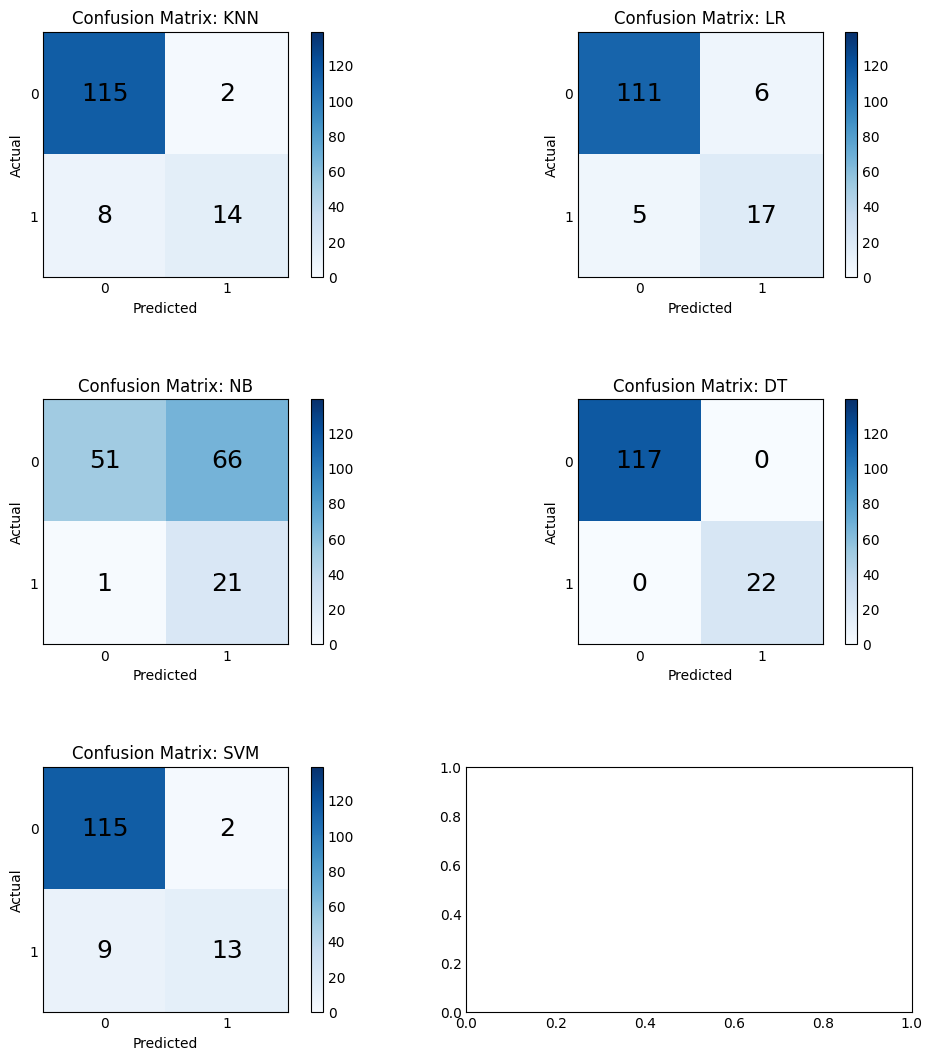

In [23]:
plt.style.use("_mpl-gallery-nogrid")

fig, axes = plt.subplots(3, 2, figsize=(10, 10))
plt.subplots_adjust(hspace=0.5)

for i, ((model_name, predicted_labels), ax) in enumerate(zip(prediction.items(), axes.flatten())):
    cm = confusion_matrix(Y_test, predicted_labels)
    hm = ax.imshow(cm, interpolation="nearest", cmap="Blues")
    classes = np.unique(Y_test)
    tick_marks = np.arange(len(classes))
    ax.set_xticks(tick_marks, labels=classes)  # X-axis scale and labels
    ax.set_yticks(tick_marks, labels=classes)  # Y-axis scale and labels
    ax.set(title=f"Confusion Matrix: {model_name}", xlabel="Predicted", ylabel="Actual")
    hm.set_clim((0, len(Y_test)))
    cbar = fig.colorbar(mappable=hm)  # This is the color bar at the right

    # Display the values in each cell
    for i in range(len(classes)):
        for j in range(len(classes)):
            ax.text(j, i, str(cm[i, j]), ha="center", va="center", size=18)

plt.show()


From the Classification Report and Confusion Matrix, we can observe that the performance of the GaussianNB model is noticeably inferior to the others.

These models have an accuracy rate of 90% or above in their predictions, except for the GaussianNB.

## Cross Validation